In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression

from scipy.stats import norm

np.random.seed(1)

## IWA algorithm - Toy example

In [2]:
def g(x):
    return np.sin(x * np.pi) / (x * np.pi)

def w(x):
    return norm.pdf(x, loc=2, scale=0.25) / norm.pdf(x, loc=1, scale=0.5)

### Algorithm 1

In [ ]:
def calculate_aggregation_weight(F_s, F_t, y_s, betas):
    l = F_s.shape[0]
    m = F_t.shape[1]
    n = F_s.shape[1]
    G = np.zeros((l, l))
    for p in range(l):
        for q in range(l):
            G[p, q] = np.matmul(F_t[p].flatten() , F_t[q].flatten()) / m
    F = np.zeros((l, 1))
    for k in range(l):
        F_ = np.zeros((n, 1))
        for i in range(n):
            F_[i] = (betas[i] * y_s[i] * F_s[k, i]) / n
        F[k] = np.sum(F_)

    c_hat = np.matmul(np.linalg.pinv(G), F)
    return c_hat

def calculate_aggergation_error(c_hats,slopes_intercepts_list,number_test_samples):
    agg_errors=[]
    target_test_X = np.random.randn(number_test_samples, 1) * 0.25 + 2
    target_test_Y = g(target_test_X) + np.random.randn(number_test_samples, 1) * 0.25
    modell_agg=np.zeros((number_test_samples,1))
    agg_slope=0
    agg_intercept=0
    for key,value in slopes_intercepts_list.items():
        modell_agg=modell_agg+c_hats[key]*(value[0]*target_test_X+ value[1])
        agg_slope+=c_hats[key]*value[0]
        agg_intercept+=c_hats[key]*value[1]
    agg_error = np.mean((modell_agg - target_test_Y) ** 2)
    return agg_error, agg_slope, agg_intercept

In [3]:
target_errors = []
source_errors = []
iwcv_errors = []
dev_errors = []
F_s=[]
F_t=[]

slopes_intercepts_list=dict({0: [0.5,0.5]})


source_X = np.random.randn(1500, 1) * 0.5 + 1
source_Y = g(source_X) + np.random.randn(1500, 1) * 0.25

betas = w(source_X)

model1 = LinearRegression()
model1.fit(source_X, source_Y)

s_i=[model1.coef_[0][0],model1.intercept_[0]]
slopes_intercepts_list[1]=s_i

model2=LinearRegression()
model2.fit(source_X, source_Y, betas.flatten())

rand_num = np.random.randn()
s_i=[model2.coef_[0][0]+rand_num*0.4+0.2,model2.intercept_[0]]
slopes_intercepts_list[2]=s_i

rand_num = np.random.randn()
s_i=[model2.coef_[0][0]+rand_num*0.4+0.2,model2.intercept_[0]]
slopes_intercepts_list[3]=s_i  

print("slopes_intercepts_list1:", slopes_intercepts_list)       

target_X = np.random.randn(1500, 1) * 0.25 + 2
target_Y = g(target_X) + np.random.randn(1500, 1) * 0.25

for value in slopes_intercepts_list.values():
    
    model_output_s=source_X*value[0]+value[1]
    model_output_t=target_X*value[0]+value[1]
    target_error = np.mean((target_Y - model_output_t) ** 2)
    source_error = np.mean((source_Y - model_output_s) ** 2)

    wl = betas * ((source_Y - model_output_s) ** 2)
    weighted_val_error = np.mean(wl)

    cov = np.cov(np.concatenate((wl, betas), axis=1), rowvar=False)[0][1]
    var_w = np.var(betas, ddof=1)
    c = - cov / var_w

    dev_error = weighted_val_error + c * np.mean(betas) - c
    
    F_s.append(model_output_s)
    F_t.append(model_output_t)

    target_errors.append(target_error)
    source_errors.append(source_error)
    iwcv_errors.append(weighted_val_error)
    dev_errors.append(dev_error)
    
F_s=np.array(F_s)
F_t=np.array(F_t)

print(F_s.shape)

c_hats=calculate_aggregation_weight(F_s, F_t, source_Y, betas)
agg_error, agg_slope, agg_intercept=calculate_aggergation_error(c_hats,slopes_intercepts_list,number_test_samples=1500)
print(agg_error)
print(target_errors)
print("slopes_intercepts_list:", slopes_intercepts_list)

slopes_intercepts_list1: {0: [0.5, 0.5], 1: [-0.6214121652583009, 0.7676813231414747], 2: [0.6044760131030948, -0.8580392727271542], 3: [0.718448902775255, -0.8580392727271542]}
(4, 1500, 1)
0.06570576747999525
[2.3548467863389635, 0.34530313601092605, 0.19902449962998972, 0.42235087005623617]
slopes_intercepts_list: {0: [0.5, 0.5], 1: [-0.6214121652583009, 0.7676813231414747], 2: [0.6044760131030948, -0.8580392727271542], 3: [0.718448902775255, -0.8580392727271542]}


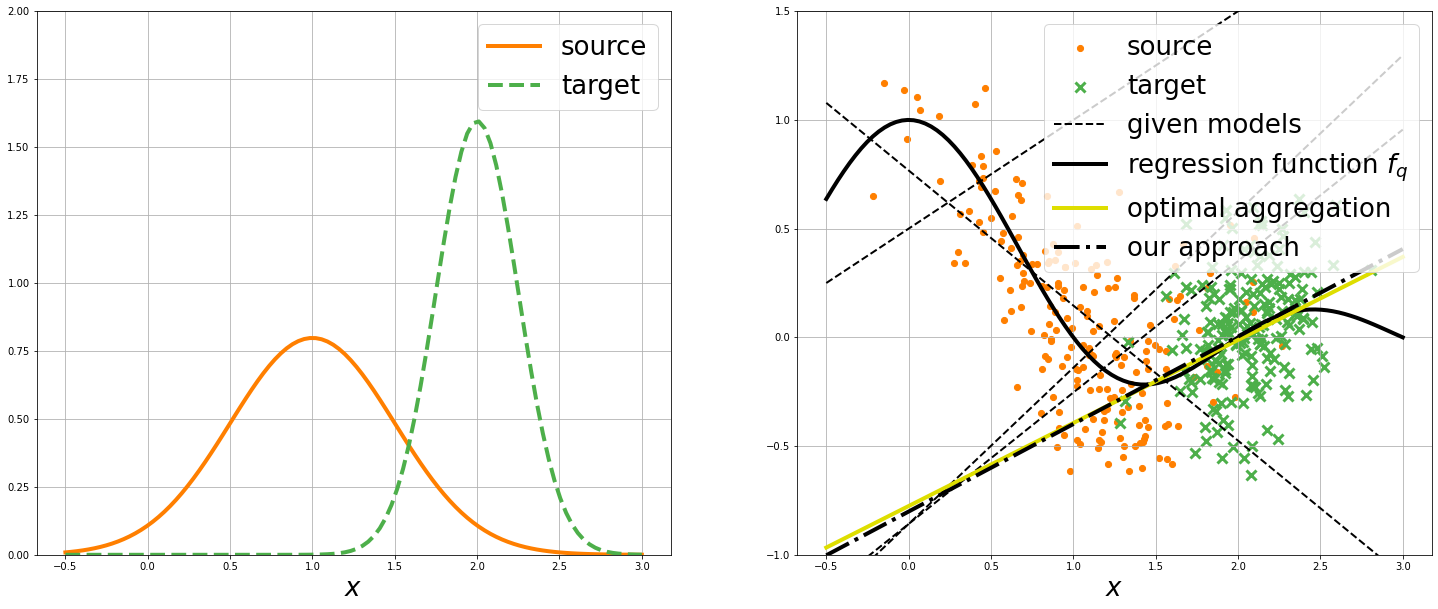

In [4]:
n_points = 200
x = np.linspace(-0.5, 3, 100)
h = np.linspace(-0.5, 3, 100)
line= []
for value in slopes_intercepts_list.values():
    line.append(value)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(25,10))
plt.rcParams['font.size'] = '26'

ax1.plot(x, norm.pdf(x, loc=1,scale=0.5),label='source',c = '#ff7f00',linewidth=4)
ax1.plot(x, norm.pdf(x, loc=2, scale=0.25),c = '#4daf4a',label="target",linestyle='dashed',linewidth=4)
ax1.set_xlabel('$x$',fontsize=26)
ax1.set_ylim([0,2])
ax1.grid(True)
ax1.legend()

ax2.scatter(source_X[0:n_points],source_Y[0:n_points],facecolors='#ff7f00',marker="." ,edgecolors='#ff7f00',label='source',s=150)
ax2.scatter(target_X[0:n_points],target_Y[0:n_points],marker='x',color='#4daf4a',label='target',s=100,linewidth=3)
line0, = ax2.plot(x, x*line[0][0]+line[0][1],c='black',linestyle='dashed',label='given models',linewidth=2)
line1, = ax2.plot(x, x*line[1][0]+line[1][1],c='black',linestyle='dashed',linewidth=2)
line2, = ax2.plot(x, x*line[2][0]+line[2][1],c='black',linestyle='dashed',linewidth=2)
line3, = ax2.plot(x, x*line[3][0]+line[3][1],c='black',linestyle='dashed',linewidth=2)
line_yellow = ax2.plot(h,g(h),label='regression function $f_q$',color='black',linewidth=4)
line_grey = ax2.plot(x, x*0.381879-0.775692, color='#dede00',label="optimal aggregation",linewidth=4)
line_agg = ax2.plot(x, x*agg_slope+agg_intercept,linestyle='-.',label='our approach',color='black',linewidth=4)
ax2.set_ylim([-1,1.5])
ax2.set_xlabel('$x$',fontsize=26)
leg = ax2.legend(loc='upper right')
ax2.legend()
ax2.grid(True)

plt.savefig('output.png', dpi=300, bbox_inches='tight')
